# 🧪🔥 **Predicting Melting Points - Feature Engineering + LGBM Model + External Datasets**

> *Predict when molecules stop being cool; where solid science meets the loss function...*

Hey guys, welcome to my **Melting Point Prediction** public notebook!  
We’re diving deep into the thermochemical abyss to **predict how quickly organic compounds melt under pressure** — literally.  

---

### 💡 Mission
Our goal is to use machine learning + chemical intuition + external datasets (and a dash of RDKit black-magic) to predict melting points (°C) from molecular structures.

We’ll turn **cryptic SMILES** strings like  
`CCOC(=O)c1ccc(O)cc1`  
into a **molten cauldron** of features:
- 🔬 RDKit descriptors  
- ⚙️ Fingerprints (Morgan & MACCS)  
- 🌍 3D shape & polarity stats  
- 🧊 Packing, bonding & H-bonding features  
- 🧠 And a few “I-have-no-idea-but-it-works” features

---

### 🧰 Toolkit (Just the Core)
| Library | Role |
|:--------|:-----|
| 🧬 **RDKit** | Molecular wizardry 🧙‍♂️ — descriptors, fragments, and shape |
| 🧠 **LightGBM** | Brain of the operation |
| 🧪 **Pandas + NumPy** | Lab assistants for data wrangling |
| ⚡ **Joblib** | Parallel feature extraction for impatient chemists |
| 🎨 **Matplotlib + Seaborn** | Because science should *look* beautiful too |
| 🔮 **Optuna** | The hyperparameter oracle that whispers, *“try this next”* 🎯 |

---

### ⚗️ What’s inside
- Canonical SMILES parsing (no doppelgänger molecules!)
- 2D descriptors, VSA bins, EState stats  
- Hydrogen bonding, heteroatoms, aromaticity galore  
- Optional ⚡ *Lean 3D geometry features*
- Fingerprint vectors for pattern-hungry models  
- Custom polarity & flexibility indicators for extra flavor 🌶️ - (hopefully!)

---

### 🧊 Results ➡ MAE=~6.56 !!!**

---

In [1]:
!pip install rdkit
!pip install pingouin 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.5 MB/s eta 0:00:00


In [2]:
# libraries
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import optuna
import pandas as pd
import pingouin as pg
import seaborn as sns
import sys
import warnings
from catboost import CatBoostRegressor
from functools import lru_cache
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from rdkit import Chem, rdBase, RDLogger
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, Lipinski, Fragments, AllChem, rdFingerprintGenerator, RDKFingerprint
from rdkit.Chem.AllChem import ComputeGasteigerCharges
from rdkit.Chem.MACCSkeys import GenMACCSKeys
from rdkit.Chem.EState import EState_VSA, AtomTypes as EAtomTypes
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.Scaffolds import MurckoScaffold
from scipy.special import inv_boxcox
from scipy.stats import boxcox, norm
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBRegressor
from tqdm import tqdm

# configuration
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 120)
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")

# 1. Load

## 1.1. Load Standard Datasets

In [3]:
# train data
df_train = pd.read_csv("/kaggle/input/melting-point/train.csv", sep=",")[['SMILES', 'Tm']]
print(df_train.shape)
df_train.head(1)

(2662, 2)


,SMILES,Tm
0,FC1=C(F)C(F)(F)C1(F)F,213.15


In [4]:
# test data
df_test = pd.read_csv("/kaggle/input/melting-point/test.csv", sep=",")[['id', 'SMILES']]
print(df_test.shape)
df_test.head(1)

(666, 2)


,id,SMILES
0,1022,CCOC(=O)c1ccc(O)cc1


In [5]:
# sample submission
sample_submission = pd.read_csv("/kaggle/input/melting-point/sample_submission.csv", sep=",")
print(sample_submission.shape)
sample_submission.head(1)

(666, 2)


,id,Tm
0,1022,0


## 1.2. Load External Datasets

In [6]:
def regression_metrics(y_val, pred_val):
    """ show metrics for selected two continuous columns to be
        compared with each other 
    """   
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    return {
        'R2': round(r2_score(y_val, pred_val), 3),
        'MAE': round(mean_absolute_error(y_val, pred_val), 3),
        'MAPE': round(mean_absolute_percentage_error(y_val, pred_val), 3),
        'RMSE': round(root_mean_squared_error(y_val, pred_val), 3),
        'sample_size': len(y_val),    
    }

In [7]:
# load external data: smiles_melting_point
df_smiles = pd.read_csv("/kaggle/input/external-melting-point-datasets/smiles_melting_point.csv", on_bad_lines='skip' )
df_smiles = df_smiles[["SMILES", "Melting Point {measured, converted}"]]
df_smiles = df_smiles.rename(columns={'Melting Point {measured, converted}': 'Tm', 'NAME': 'name'})
df_smiles.shape

(274978, 2)

In [8]:
# performance on training dataset
df_inner = df_train[["SMILES", "Tm"]].merge(df_smiles, how="inner", on="SMILES")
df_inner.info()
regression_metrics(df_inner.Tm_x, df_inner.Tm_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  589 non-null    object 
 1   Tm_x    589 non-null    float64
 2   Tm_y    589 non-null    float64
dtypes: float64(2), object(1)
memory usage: 13.9+ KB


{'R2': 0.659, 'MAE': 9.196, 'MAPE': 0.023, 'RMSE': 48.262, 'sample_size': 589}

In [9]:
# load external data: bradley
df_bradley = pd.read_excel('/kaggle/input/external-melting-point-datasets/BradleyMeltingPointDataset.xlsx')
df_bradleyplus = pd.read_excel('/kaggle/input/external-melting-point-datasets/BradleyDoublePlusGoodMeltingPointDataset.xlsx')
df_bradley['Tm'] = df_bradley['mpC'].map(lambda x : x + 273.15)
df_bradleyplus['Tm'] = df_bradleyplus['mpC'].map(lambda x: x + 273.15)
df_bradley = df_bradley[['smiles', 'Tm']]
df_bradleyplus = df_bradleyplus[['smiles', 'Tm']]
df_bradley = pd.concat((df_bradley, df_bradleyplus), axis=0)
df_bradley = df_bradley.rename(columns = {'smiles':'SMILES'})
df_bradley.shape

(31686, 2)

In [10]:
# performance on training dataset
df_inner = df_train[["SMILES", "Tm"]].merge(df_bradley, how="inner", on="SMILES")
df_inner.info()
regression_metrics(df_inner.Tm_x, df_inner.Tm_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2487 entries, 0 to 2486
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  2487 non-null   object 
 1   Tm_x    2487 non-null   float64
 2   Tm_y    2487 non-null   float64
dtypes: float64(2), object(1)
memory usage: 58.4+ KB


{'R2': 0.778, 'MAE': 7.488, 'MAPE': 0.019, 'RMSE': 41.471, 'sample_size': 2487}

## 1.3. Extend Training Data

In [11]:
def canonicalize(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None

In [12]:
# canonicalize all smiles: unique descriptor
df_train['SMILES'] = df_train['SMILES'].apply(canonicalize)
df_test['SMILES'] = df_test['SMILES'].apply(canonicalize)
df_smiles['SMILES'] = df_smiles['SMILES'].apply(canonicalize)
df_bradley['SMILES'] = df_bradley['SMILES'].apply(canonicalize)

In [13]:
# add all together
df_train = pd.concat([df_smiles, df_bradley, df_train], axis=0)
df_train.drop_duplicates(subset='SMILES', keep='last', inplace=True)
df_train.dropna(ignore_index=True, inplace=True)
df_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278684 entries, 0 to 278683
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SMILES  278684 non-null  object 
 1   Tm      278684 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.3+ MB


In [14]:
# any overlapping test <-> train (after external data added)
df_test = df_test.merge(df_train, how="left", on="SMILES")
df_test[["SMILES", "Tm"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  666 non-null    object 
 1   Tm      652 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.5+ KB


In [15]:
# sample train data
# TODO: FEEL FREE TO USE FULL-EXTENDED TRAIN DATA: BUT I NEED TO SAMPLE HERE SINCE KAGGLE LEADS TO MEMORY PROBLEMS!!!
df_train = df_train.sample(10000).reset_index(drop=True)

# 2. SMILES Engineering

We don’t just read **SMILES** — we *decode* them.  
Each molecule is stripped down, analyzed, rebuilt, and then showered with hundreds of engineered features — all designed to capture what makes it melt. We will also do some feature selection later to keep important signals in and getting rid of the stuff that has only noise.  

### 🧪 What We Extract:
- **📏 Physicochemical descriptors**: molecular weight, logP, TPSA, rings, donors/acceptors.  
- **🧬 Fingerprints**: Morgan + MACCS (our chemical DNA barcodes).  
- **🌍Lean 3D geometry**: radius of gyration, PMI ratios, shape factors — *no CPU meltdown required*.  
- **⚡ Charge & polarity**: Gasteiger charges, EState indices, heteroatom fractions.  
- **🧱 Structural patterns**: aromaticity, ring systems, hydrogen bonding, conjugation.  
- **🧠 Clever interactions**: ratio-based features like rigidity, flexibility, or H-bond capacity per atom.  

### Making It Fast:
- Parallelized feature extraction.  
- Cached 3D embeddings → computed **once per unique SMILES**.  
- Lean 3D pipeline (no heavy optimization, no hydrogens, just pure geometry).  
- Dropped duplicate & constant columns — no baggage, no fluff.  

*Result:* on a sample of 3000 molecules, full feature set computed in under **90 seconds**.  

In [16]:
def _safe(f, default=None):
    def wrap(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except Exception:
            return default
    return wrap

def _count_atoms(m, symbols):
    s = set(symbols)
    return sum(1 for a in m.GetAtoms() if a.GetSymbol() in s)

def _largest_ring_size(m):
    ri = m.GetRingInfo()
    return max((len(r) for r in ri.AtomRings()), default=0)

def count_smarts(m, patt):
    return len(m.GetSubstructMatches(patt))

def count_explicit_h(m):
    mH = Chem.AddHs(m)
    return sum(1 for a in mH.GetAtoms() if a.GetSymbol() == "H")

def drop_constant_and_duplicate_columns(df):
    # drop constant columns
    nunique = df.nunique(dropna=False)
    constant_cols = nunique[nunique <= 1].index.tolist()
    df = df.drop(columns=constant_cols)
    # drop duplicate columns
    df = df.loc[:, ~df.T.duplicated(keep='first')]
    return df

def _pick(*cands):
    """Return first callable among names across modules."""
    for mod, name in cands:
        fn = getattr(mod, name, None)
        if callable(fn):
            return fn
    return None

def gasteiger_stats(m):
    m = Chem.AddHs(m)
    ComputeGasteigerCharges(m)
    vals = []
    for a in m.GetAtoms():
        v = a.GetDoubleProp('_GasteigerCharge') if a.HasProp('_GasteigerCharge') else 0.0
        if pd.isna(v) or v == float('inf') or v == float('-inf'):
            v = 0.0
        vals.append(v)
    arr = np.array(vals, dtype=float)
    return {
        "Gasteiger_q_sum": float(arr.sum()),
        "Gasteiger_q_abs_sum": float(np.abs(arr).sum()),
        "Gasteiger_q_min": float(arr.min(initial=0.0)),
        "Gasteiger_q_max": float(arr.max(initial=0.0)),
        "Gasteiger_q_std": float(arr.std(ddof=0)),
    }

MORGAN_BITS   = 512
MORGAN_RADIUS = 2
USE_MACCS     = True

def _shape3d_worker(cansmi: str, maxIters: int = 0):
    """Compute fast 3D shape features for ONE canonical SMILES (embed with explicit Hs, compute shape without Hs)."""
    try:
        m = Chem.MolFromSmiles(cansmi)
        if m is None:
            return cansmi, {}

        # --- Add explicit Hs for embedding/optimization (silences the “explicit Hs” spam) ---
        mH = Chem.AddHs(m)

        params = AllChem.ETKDGv3()
        params.randomSeed = 123
        params.useRandomCoords = True

        with Chem.WrapLogs():
            cid = AllChem.EmbedMolecule(mH, params)
        if cid < 0:
            with Chem.WrapLogs():
                cid = AllChem.EmbedMolecule(mH, randomSeed=123)
            if cid < 0:
                return cansmi, {}

        if maxIters and maxIters > 0:
            try:
                with Chem.WrapLogs():
                    AllChem.UFFOptimizeMolecule(mH, confId=cid, maxIters=int(maxIters))
            except Exception:
                pass

        # --- Remove Hs before computing shape (keeps heavy-atom shape behavior) ---
        # After RemoveHs, conformers are reindexed; use confId = 0.
        m_noH = Chem.RemoveHs(mH)
        confId = 0

        out = {}
        for nm, fn in [
            ("RadiusOfGyration", rdMolDescriptors.CalcRadiusOfGyration),
            ("InertialShapeFactor", rdMolDescriptors.CalcInertialShapeFactor),
            ("PMI1", rdMolDescriptors.CalcPMI1),
            ("PMI2", rdMolDescriptors.CalcPMI2),
            ("PMI3", rdMolDescriptors.CalcPMI3),
            ("NPR1", rdMolDescriptors.CalcNPR1),
            ("NPR2", rdMolDescriptors.CalcNPR2),
        ]:
            try:
                with Chem.WrapLogs():
                    out[nm] = float(fn(m_noH, confId=confId))
            except Exception:
                out[nm] = 0.0

        pmi1 = out.get("PMI1", 0.0) or 0.0
        pmi2 = out.get("PMI2", 0.0) or 0.0
        pmi3 = out.get("PMI3", 0.0) or 0.0
        out["PMI2_over_PMI1"] = (pmi2 / pmi1) if pmi1 else 0.0
        out["PMI3_over_PMI1"] = (pmi3 / pmi1) if pmi1 else 0.0

        return cansmi, out
    except Exception:
        return cansmi, {}

def precompute_shape3d_cache(smiles_series, n_jobs=None, maxIters=0):
    n_jobs = n_jobs or max(1, mp.cpu_count() - 1)
    # canonicalize & unique
    can = smiles_series.astype(str).apply(lambda s: Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True)
                                          if pd.notna(s) and Chem.MolFromSmiles(s) is not None else None)
    uniq = sorted(x for x in set(can.tolist()) if x is not None)

    if not uniq:
        return {}

    results = Parallel(n_jobs=n_jobs, backend="loky", batch_size=64)(
        delayed(_shape3d_worker)(s, maxIters) for s in uniq
    )
    return {k: v for k, v in results if k is not None}

def _bond_order(b):
    # return 1,2,3 or 1.5 for aromatic
    if b.GetIsAromatic():
        return 1.5
    t = b.GetBondType()
    if t == Chem.BondType.SINGLE: return 1
    if t == Chem.BondType.DOUBLE: return 2
    if t == Chem.BondType.TRIPLE: return 3
    return 0

def _ring_size_hist(m):
    ri = m.GetRingInfo()
    sizes = [len(r) for r in ri.AtomRings()]
    out = {5:0, 6:0, 7:0, 8:0}
    for s in sizes:
        if s in out: out[s] += 1
    return out, len(sizes)

def _ring_systems_count(m):
    # crude fused ring systems count via BFS over rings sharing atoms
    ri = m.GetRingInfo()
    rings = [set(r) for r in ri.AtomRings()]
    if not rings: return 0
    seen = set()
    sys = 0
    for i in range(len(rings)):
        if i in seen: continue
        sys += 1
        stack = [i]
        seen.add(i)
        while stack:
            j = stack.pop()
            for k in range(len(rings)):
                if k in seen: continue
                if rings[j] & rings[k]:
                    seen.add(k); stack.append(k)
    return sys

def _murcko_stats(m):
    try:
        scaf = MurckoScaffold.GetScaffoldForMol(m)
        if scaf is None or scaf.GetNumAtoms() == 0:
            return {"MurckoAtoms":0, "MurckoRings":0, "MurckoRingSystems":0, "SideChainAtoms":m.GetNumAtoms()}
        msys = _ring_systems_count(scaf)
        return {
            "MurckoAtoms": scaf.GetNumAtoms(),
            "MurckoRings": rdMolDescriptors.CalcNumRings(scaf),
            "MurckoRingSystems": msys,
            "SideChainAtoms": m.GetNumAtoms() - scaf.GetNumAtoms(),
        }
    except Exception:
        return {"MurckoAtoms":0, "MurckoRings":0, "MurckoRingSystems":0, "SideChainAtoms":m.GetNumAtoms()}

def _estate_stats(m):
    try:
        vals = EAtomTypes.EStateIndices(m)  # per-atom EState
        if not vals: return {"EState_sum":0.0,"EState_mean":0.0,"EState_max":0.0,"EState_min":0.0,"EState_std":0.0}
        import numpy as np
        arr = np.asarray(vals, dtype=float)
        return {
            "EState_sum": float(arr.sum()),
            "EState_mean": float(arr.mean()),
            "EState_max": float(arr.max()),
            "EState_min": float(arr.min()),
            "EState_std": float(arr.std(ddof=0)),
        }
    except Exception:
        return {"EState_sum":0.0,"EState_mean":0.0,"EState_max":0.0,"EState_min":0.0,"EState_std":0.0}

def _smiles_morphology(smi: str):
    if not smi: 
        return {"SMI_len":0,"SMI_branches":0,"SMI_ringDigits":0,"SMI_stereoAt":0,"SMI_ezSlashes":0}
    return {
        "SMI_len": len(smi),
        "SMI_branches": smi.count("("),
        "SMI_ringDigits": sum(ch.isdigit() for ch in smi),
        "SMI_stereoAt": smi.count("@"),
        "SMI_ezSlashes": smi.count("/") + smi.count("\\"),
    }

def augment_extra_cheaps(row, m):
    # ---- EState summaries ----
    row.update(_estate_stats(m))

    # ---- Bond order / saturation / conjugation ----
    bonds = list(m.GetBonds())
    nb = max(len(bonds), 1)
    n_single = sum(1 for b in bonds if b.GetBondType() == Chem.BondType.SINGLE and not b.GetIsAromatic())
    n_double = sum(1 for b in bonds if b.GetBondType() == Chem.BondType.DOUBLE)
    n_triple = sum(1 for b in bonds if b.GetBondType() == Chem.BondType.TRIPLE)
    n_arom   = sum(1 for b in bonds if b.GetIsAromatic())
    row["FracSingle"]  = n_single / nb
    row["FracDouble"]  = n_double / nb
    row["FracTriple"]  = n_triple / nb
    row["FracAromatic"]= n_arom   / nb
    row["MeanBondOrder"]= (sum(_bond_order(b) for b in bonds) / nb) if nb>0 else 0.0
    # simple conjugation proxy: count alternating unsat/aromatic bonds
    row["UnsatBondCount"] = n_double + n_triple + n_arom

    # ---- Ring size distribution + fused systems ----
    hist, n_rings = _ring_size_hist(m)
    row["Rings5"] = hist[5]; row["Rings6"] = hist[6]
    row["Rings7"] = hist[7]; row["Rings8"] = hist[8]
    row["RingSystems"] = _ring_systems_count(m)
    row["Rings56_frac"] = (hist[5] + hist[6]) / (n_rings if n_rings>0 else 1)

    # ---- Murcko scaffold stats ----
    row.update(_murcko_stats(m))

    # ---- Charge / zwitterion flags ----
    tot_charge = sum(a.GetFormalCharge() for a in m.GetAtoms())
    has_pos = any(a.GetFormalCharge() > 0 for a in m.GetAtoms())
    has_neg = any(a.GetFormalCharge() < 0 for a in m.GetAtoms())
    row["FormalCharge"] = int(tot_charge)
    row["IsZwitterion"] = int(has_pos and has_neg)

    # ---- SMILES morphology (cheap string features) ----
    try:
        smi = Chem.MolToSmiles(m, canonical=True)
    except Exception:
        smi = ""
    row.update(_smiles_morphology(smi))

    return row

def reduce_memory_usage(df):
    """ reduce memory used by the dataframe by converting into 
        more memory friendly data types
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        # numerical
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # categorical
        elif col_type == object:
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:  # Heuristic: low cardinality
                df[col] = df[col].astype('category')
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def rdkit_feature_row(m, compute_3d=False, shape_cache=None):
    row = {}

    # ---- 1) Built-in descriptor list (2D)
    for name, func in Descriptors._descList:
        row[name] = _safe(func)(m)

    # Common extras that aren’t always in _descList
    row["MolLogP"], row["MolMR"] = _safe(Crippen.MolLogP)(m), _safe(Crippen.MolMR)(m)
    row["NumHAcceptors"], row["NumHDonors"] = _safe(Lipinski.NumHAcceptors)(m), _safe(Lipinski.NumHDonors)(m)
    row["NumRings"] = _safe(rdMolDescriptors.CalcNumRings)(m)
    row["NumAromaticRings"] = _safe(rdMolDescriptors.CalcNumAromaticRings)(m)
    row["NumAliphaticRings"] = _safe(rdMolDescriptors.CalcNumAliphaticRings)(m)
    row["NumSaturatedRings"] = _safe(rdMolDescriptors.CalcNumSaturatedRings)(m)
    row["NumBridgeheadAtoms"] = _safe(rdMolDescriptors.CalcNumBridgeheadAtoms)(m)
    row["NumSpiroAtoms"]      = _safe(rdMolDescriptors.CalcNumSpiroAtoms)(m)
    row["LargestRingSize"] = _safe(_largest_ring_size)(m)
    row["NumAmideBonds"] = _safe(rdMolDescriptors.CalcNumAmideBonds)(m)
    row["TPSA"] = _safe(rdMolDescriptors.CalcTPSA)(m)
    row["LabuteASA"] = _safe(rdMolDescriptors.CalcLabuteASA)(m)

    # Element counts
    if m is None:
        for el in ["C","H","N","O","S","F","Cl","Br","I","P"]:
            row[f"Count_{el}"] = 0
    else:
        for el in ["C","N","O","S","F","Cl","Br","I","P"]:
            row[f"Count_{el}"] = _count_atoms(m, [el])
        row["Count_H"] = _safe(count_explicit_h)(m)

    # ---- 2a) Fragment/group counts (built-in RDKit fragments only)
    for attr in dir(Fragments):
        if attr.startswith("fr_"):
            fn = getattr(Fragments, attr)
            if callable(fn):
                row[attr] = _safe(fn)(m)

    # ---- 2b) Fingerprints: Morgan (binary) + MACCS (fast, high value)
    try:
        if m is not None:
            # Morgan binary (no countSimulation → faster & leaner)
            mgen = rdFingerprintGenerator.GetMorganGenerator(
                radius=MORGAN_RADIUS, fpSize=MORGAN_BITS, countSimulation=False
            )
            mfp = mgen.GetFingerprint(m)
            for i in range(MORGAN_BITS):
                row[f"Morgan_{i}"] = int(mfp[i])
        else:
            for i in range(MORGAN_BITS):
                row[f"Morgan_{i}"] = 0

        if USE_MACCS:
            if m is not None:
                maccs = GenMACCSKeys(m)                     # 167 bits
                for i in range(len(maccs)):
                    row[f"MACCS_{i}"] = int(maccs[i])
            else:
                for i in range(167):
                    row[f"MACCS_{i}"] = 0
    except Exception:
        # safety net: if FP gen fails for any reason, fill zeros and keep going
        for i in range(MORGAN_BITS):
            row.setdefault(f"Morgan_{i}", 0)
        if USE_MACCS:
            for i in range(167):
                row.setdefault(f"MACCS_{i}", 0)

    # ---- 3) VSA binnings / EState VSA (surface/charge environments)
    for vsa_name, vsa_fn in [
        ("SlogP_VSA", getattr(rdMolDescriptors, "SlogP_VSA_", None)),
        ("SMR_VSA",   getattr(rdMolDescriptors, "SMR_VSA_", None)),
        ("EState_VSA",getattr(rdMolDescriptors, "EState_VSA_", None)),
    ]:
        if vsa_fn is None:
            continue
        try:
            bins = vsa_fn(m)
            for i, val in enumerate(bins):
                row[f"{vsa_name}{i}"] = val
            row[f"{vsa_name}_sum"] = float(sum(bins))
        except Exception:
            pass

    # ---- 4) Chi / Kappa / other indices (version-safe)
    chi_kappa_specs = [
        ("Chi0",   _pick((rdMolDescriptors,"CalcChi0n"))),
        ("Chi1",   _pick((rdMolDescriptors,"CalcChi1n"))),
        ("Chi2",   _pick((rdMolDescriptors,"CalcChi2n"))),
        ("Chi3",   _pick((rdMolDescriptors,"CalcChi3n"))),
        ("Chi4",   _pick((rdMolDescriptors,"CalcChi4n"))),
        ("Chi0v",  _pick((rdMolDescriptors,"CalcChi0v"))),
        ("Chi1v",  _pick((rdMolDescriptors,"CalcChi1v"))),
        ("Chi2v",  _pick((rdMolDescriptors,"CalcChi2v"))),
        ("Chi3v",  _pick((rdMolDescriptors,"CalcChi3v"))),
        ("Chi4v",  _pick((rdMolDescriptors,"CalcChi4v"))),
        ("Kappa1", _pick((rdMolDescriptors,"CalcKappa1"), (Descriptors,"Kappa1"))),
        ("Kappa2", _pick((rdMolDescriptors,"CalcKappa2"), (Descriptors,"Kappa2"))),
        ("Kappa3", _pick((rdMolDescriptors,"CalcKappa3"), (Descriptors,"Kappa3"))),
        ("BertzCT",_pick((rdMolDescriptors,"CalcBertzCT"), (Descriptors,"BertzCT"))),
        ("HallKierAlpha", _pick((rdMolDescriptors,"CalcHallKierAlpha"), (Descriptors,"HallKierAlpha"))),
        ("FractionCSP3",  _pick((rdMolDescriptors,"CalcFractionCSP3"), (Descriptors,"FractionCSP3"))),
    ]
    for nm, fn in chi_kappa_specs:
        if fn is not None:
            row[nm] = _safe(fn)(m)

    # ---- 4.5) Gasteiger charge features (polarity proxy)
    row.update(_safe(gasteiger_stats, {})(m))

     # ---- 5) 3D shape
    if compute_3d and m is not None:
        try:
            cansmi = Chem.MolToSmiles(m, canonical=True)
        except Exception:
            cansmi = None
        if shape_cache is not None and cansmi in shape_cache:
            row.update(shape_cache[cansmi])
        else:
            # fallback: compute quickly (single conformer, no-H, no/min opt)
            row = add_3d_features(row, m)  # your lean function

    # ---- 6a) Handy interaction/ratio features (often correlate with MP)
    hbd = row.get("NumHDonors", 0) or 0
    hba = row.get("NumHAcceptors", 0) or 0
    mw  = row.get("MolWt", 0) or 1.0
    hat = row.get("HeavyAtomCount", 0) or 1.0
    row["HBondCapacity"] = hbd + hba
    row["HBondDensity_perHeavyAtom"] = (hbd + hba) / hat
    row["RingDensity_perHeavyAtom"] = (row.get("NumRings",0) or 0) / hat
    row["HalogenCount"] = sum(row.get(k,0) for k in ["Count_F","Count_Cl","Count_Br","Count_I"])
    row["HeteroAtomFrac"] = (row.get("Count_N",0)+row.get("Count_O",0)+row.get("Count_S",0)+row.get("Count_P",0)) / hat
    row["AromRingFrac"] = (row.get("NumAromaticRings",0) or 0) / (row.get("NumRings",1) or 1)

    # ---- 6b) Extra cheap MP-focused interactions (very low cost, good value)
    hbd = row.get("NumHDonors", 0.0) or 0.0
    hba = row.get("NumHAcceptors", 0.0) or 0.0
    mw  = row.get("MolWt", 0.0) or 0.0
    tpsa = row.get("TPSA", 0.0) or 0.0
    nrot = row.get("NumRotatableBonds", 0.0) or 0.0
    narm = row.get("NumAromaticRings", 0.0) or 0.0
    mollogp = row.get("MolLogP", 0.0) or 0.0
    bertz = row.get("BertzCT", 0.0) or 0.0

    row["HBond_Product"]          = hbd * hba
    row["LogP_div_TPSA"]          = mollogp / (tpsa + 1.0)
    row["LogP_x_TPSA"]            = mollogp * tpsa
    row["Flexibility_Score"]      = nrot / (mw + 1.0)
    row["MolWt_x_AromaticRings"]  = mw * narm
    row["Complexity_per_MW"]      = bertz / (mw + 1.0)
    row["Rigidity_Score"]         = narm / (nrot + 1.0)
    row = augment_extra_cheaps(row, m)
    
    return row

def featurize_smiles(df, compute_3d=True, maxIters_3d=0):
    # molecular chemical
    mols = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s) if pd.notna(s) else None)

    # optional: precompute lean 3D cache in parallel (unique SMILES)
    shape_cache = None
    if compute_3d:
        shape_cache = precompute_shape3d_cache(df["SMILES"], n_jobs=-1, maxIters=maxIters_3d)

    # row-wise features (sequential is fine; 3D is now cached)
    feats = []
    for m in mols:
        feats.append(rdkit_feature_row(m, compute_3d=compute_3d, shape_cache=shape_cache))
    feats = pd.DataFrame(feats)

    # drop meaningless ones
    feats = drop_constant_and_duplicate_columns(feats)
    df = pd.concat([df.reset_index(drop=True), feats.reset_index(drop=True)], axis=1)
    df = reduce_memory_usage(df)
    return df

In [17]:
# apply feature engineering to train set
df_train = featurize_smiles(df_train)
df_train.info()

Memory usage decreased to 13.39 Mb (81.0% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 924 entries, SMILES to SMI_ezSlashes
dtypes: float32(127), int16(2), int8(794), object(1)
memory usage: 12.5+ MB


In [18]:
# apply feature engineering to test set
df_test = featurize_smiles(df_test, True)
df_test.info()

Memory usage decreased to  0.84 Mb (81.1% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Columns: 877 entries, id to SMI_ringDigits
dtypes: float32(126), int16(2), int8(748), object(1)
memory usage: 822.2+ KB


In [19]:
# what are extra on train/test?
extra_features_training = set(df_train.columns) - set(df_test.columns) - set(["Tm"])
extra_features_test = set(df_test.columns) - set(df_train.columns)
print(len(extra_features_training), len(extra_features_test))
df_train.drop(columns=extra_features_training, inplace=True)
df_test.drop(columns=extra_features_test, inplace=True)
print(df_train.shape, df_test.shape)

49 2
(10000, 875) (666, 875)


# 3. Check Target / Transform

In [20]:
def distribution_vs_gaussian(df, target):
    """ show the distribution of target column vs gaussian
    """ 
    _, axes = plt.subplots(1, 2, figsize=(20, 7))
    sns.histplot(df[target], kde=True, stat="density", ax=axes[0])
    mu, std = norm.fit(df[target])
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[0].plot(x, p, 'k', linewidth=2)
    axes[0].set(title='Distribution of target vs Gaussian')
    pg.qqplot(df[target], dist='norm', ax=axes[1]) 
    axes[1].set(title='QQ-Plot of Target')

def convert_object_to_category(df):
    """ return a copy of the data with category types instead of objects 
    """
    df_copy = df.copy()
    categorical_cols = df.select_dtypes(exclude=["number", "bool"])
    for col in categorical_cols:
        df_copy[col] = df_copy[col].astype('category')
    return df_copy

def calculate_vs_gaussian_r2(series):
    """ calculate the r-squared between the target and a normal distribution.
    """
    series = series.dropna().sort_values()
    # generate theoretical normal quantiles
    mean, std = series.mean(), series.std()
    theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(series)), loc=mean, scale=std)
    return round(r2_score(series, theoretical_quantiles), 4)

def target_transformation(df, target, method="log"):
    """ do transformation on the target variable. methods can be as follows:
         + log:     logarithmic transformation
         + sqrt:    square root
         + cbrt:    cubic root
         + box:     box-cox transformation
         + yeo:     yeo-johnson transformation
    """   
    new_target = target + f"_{method}"
    if method == "log":
        df[new_target] = np.log1p(df[target])
        return df
    elif method == "sqrt":
        df[new_target] = np.sqrt(df[target])
        return df
    elif method == "cbrt":
        df[new_target] = np.cbrt(df[target])
        return df
    elif method == "box":
        df[new_target], box_lam = boxcox(df[target] + 1)
        return df, box_lam
    elif method == "yeo":
        yeo_transformer = PowerTransformer(method='yeo-johnson')
        df[new_target] = yeo_transformer.fit_transform(df[target].values.reshape(-1, 1)).flatten()
        return df, yeo_transformer

def inverse_transformation(series, method, box_lam=None, yeo_transformer=None):
    """ do inverse transformation on the given series. methods can be as follows:
         + log:     logarithmic transformation
         + sqrt:    square root
         + cbrt:    cubic root
         + box:     box-cox transformation
         + yeo:     yeo-johnson transformation
    """   
    if method == "norm":
        return series
    elif method == "log":
        return np.expm1(series)
    elif method == "sqrt":
        return np.square(series)
    elif method == "cbrt":
        return np.power(series, 3)
    elif method == "box":
        return inv_boxcox(series, box_lam) - 1
    elif method == "yeo":
        return yeo_transformer.inverse_transform(series.reshape(-1, 1)).flatten()

def check_best_target_transformation(df, target):
    """ check best possible target transformation method for closest-to-gaussian
        + r2: check how close the transformed target to normal (gaussian) distribution by checking R2-score
    """
    norm = df[target].copy()
    log = np.log1p(df[target])
    sqrt = np.sqrt(df[target])
    cbrt = np.cbrt(df[target])
    box, box_lam = boxcox(df[target] + 1)
    yeo_transformer = PowerTransformer(method='yeo-johnson')
    yeo = yeo_transformer.fit_transform(df[target].values.reshape(-1, 1)).flatten()
    # dict of different approaches
    series_dict = {'norm': norm, 'log': log, 'sqrt': sqrt, 'cbrt': cbrt, 'box': box, 'yeo': yeo}
    # calculate r-squared for each
    r2_scores = {method: calculate_vs_gaussian_r2(pd.Series(data)) for method, data in series_dict.items()}
    print(r2_scores)
    # find best methodology
    best_method = max(r2_scores, key=r2_scores.get)
    best_r2 = r2_scores[best_method]
    print(f"The best transformation is '{best_method}' with an R-squared of {best_r2:.4f}")
    return box_lam, yeo_transformer

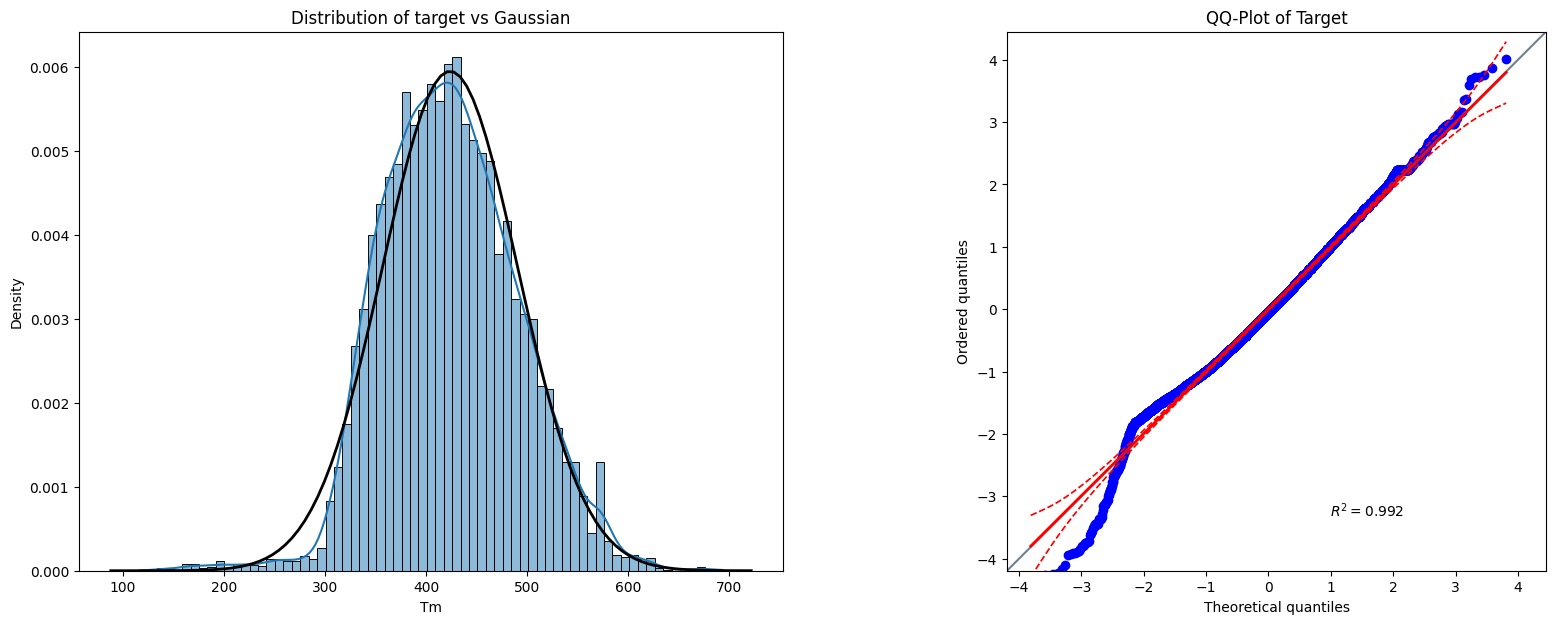

In [21]:
# target distribution
distribution_vs_gaussian(df_train, "Tm")

In [22]:
# check best target transformation
box_lam, yeo_transformer = check_best_target_transformation(df_train, "Tm")

{'norm': 0.9804, 'log': 0.9497, 'sqrt': 0.9725, 'cbrt': 0.9667, 'box': 0.98, 'yeo': 0.98}
The best transformation is 'norm' with an R-squared of 0.9804


In [23]:
# NOTE: we will keep it default since it is the most Gaussian OR a close-call depending on the train sample!

# 4. Fill Missing Features

In [24]:
# basic data imputation
numeric_cols = list(set(df_test.select_dtypes(include=["number"]).columns) - set(["Tm"]))
df_train[numeric_cols] = df_train[numeric_cols].fillna(df_train[numeric_cols].mean()).fillna(0)
df_test[numeric_cols] = df_test[numeric_cols].fillna(df_train[numeric_cols].mean()).fillna(0)    

# 5. Modeling

## 5.1. Feature Importance & Selection

In [25]:
def split_x_and_y(df, exclude, target):
    """ split target from the data 
    """
    X = df.drop(columns=exclude + [target]).copy()
    y = df[target].copy()
    return X, y

def get_feature_importance(df, exclude, target, model, no_features_in_plot=30):
    """ get feature importance by LGBMClassifier model
    """
    # split data into X and y
    X, y = split_x_and_y(df, exclude, target)
    # fit the model
    model.fit(X, y)
    # get importances
    importances = model.feature_importances_
    importances = np.round(importances / sum(importances), 4)
    sorted_idx = importances.argsort()[::-1]
    df_importance = pd.DataFrame(data={"feature": X.columns[sorted_idx].astype(str), "importance": importances[sorted_idx]})
    # summarize feature importance
    plt.figure(figsize=(15, no_features_in_plot/4))
    sns.barplot(x='importance', y='feature', data=df_importance[:no_features_in_plot], orient="h", palette="Set3")
    plt.show()
    return df_importance

In [26]:
base_models = {
    "ada": AdaBoostRegressor(random_state=42),
    "xgbr": XGBRegressor(random_state=42),
    "lgbm": LGBMRegressor(verbose=-1, random_state=42),
    "catb": CatBoostRegressor(silent=True, random_state=42),
    "rfr": RandomForestRegressor(random_state=42),
    "extra": ExtraTreesRegressor(random_state=42)
}

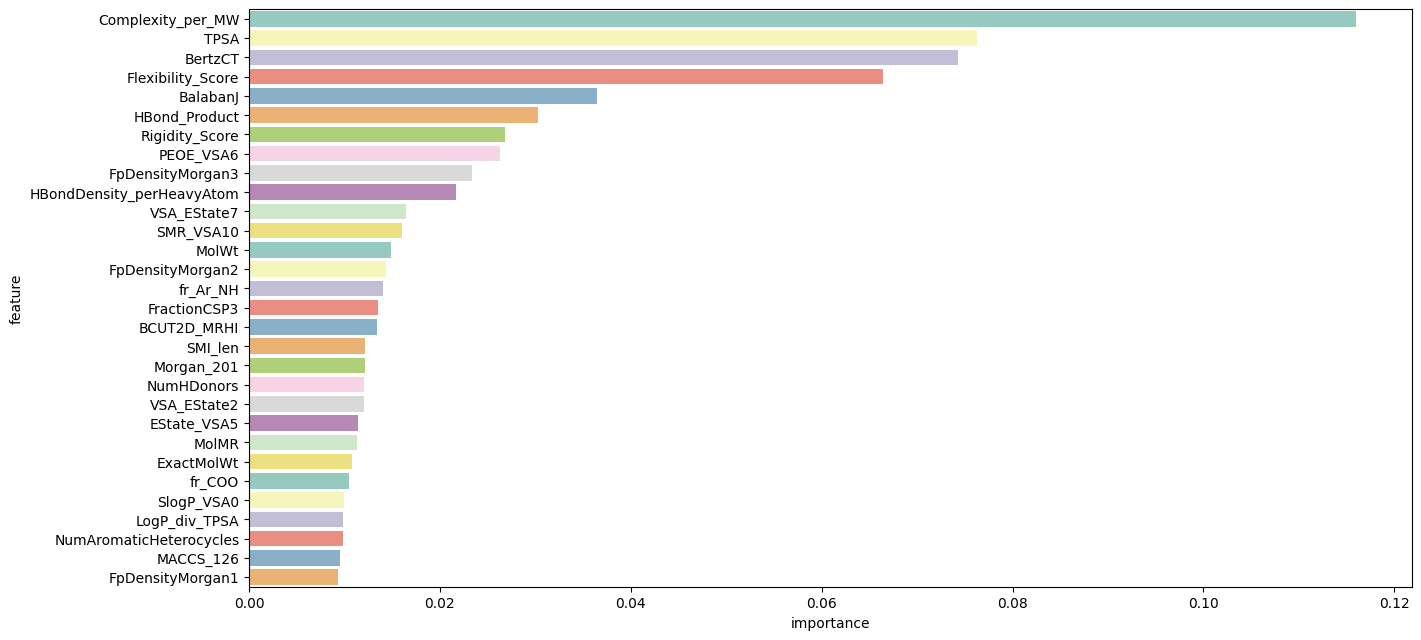

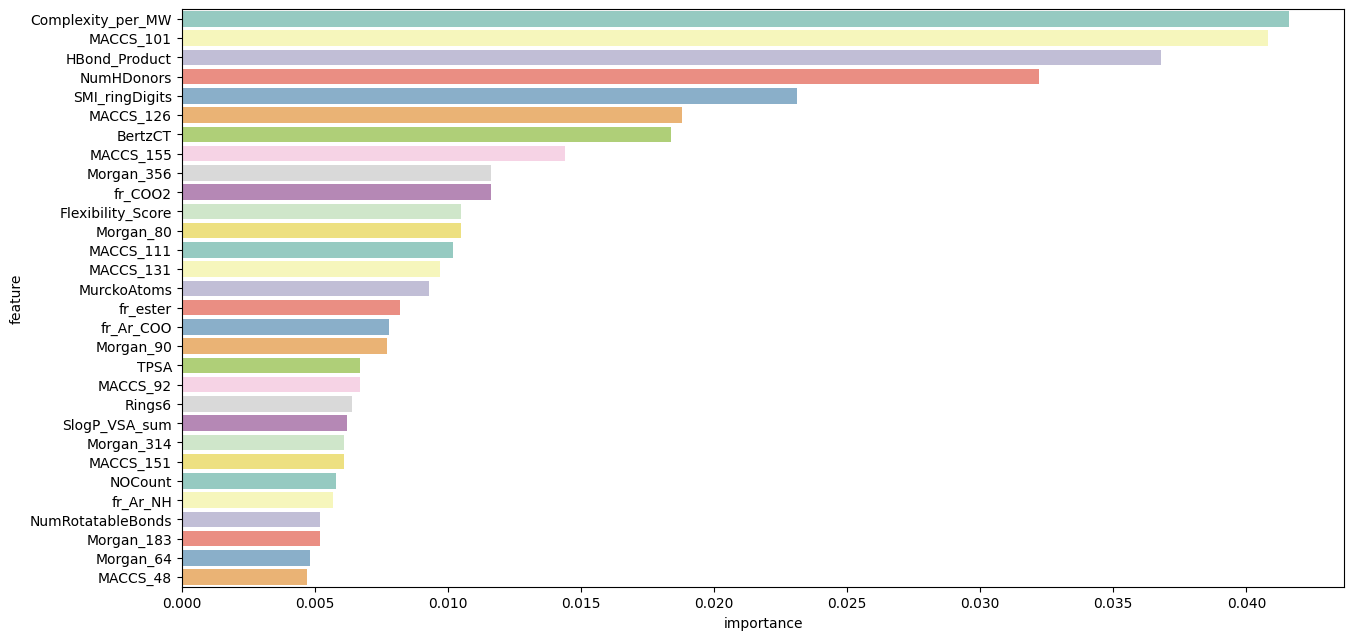

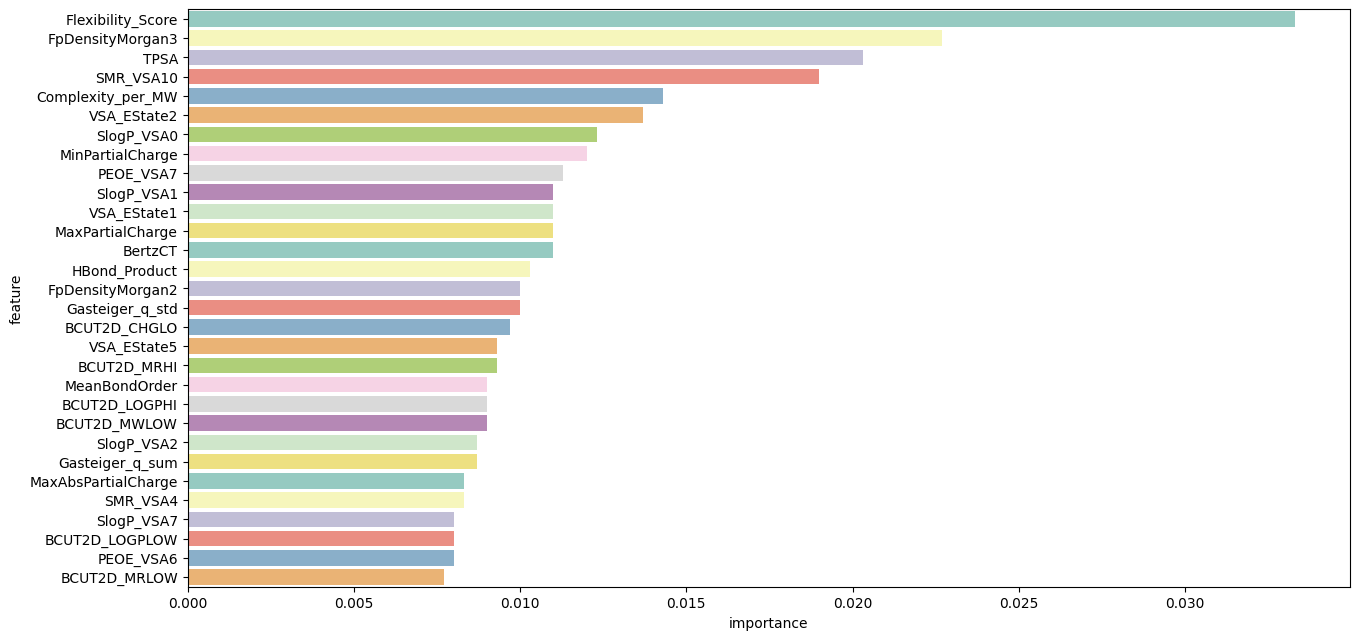

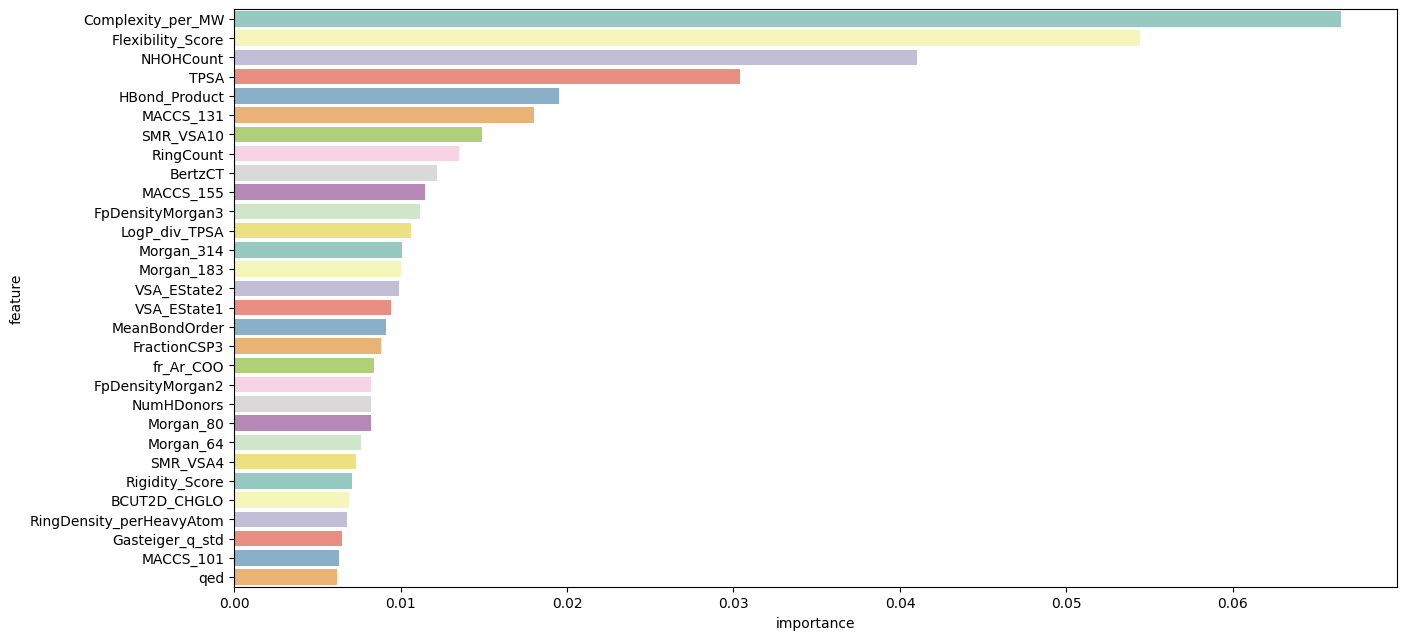

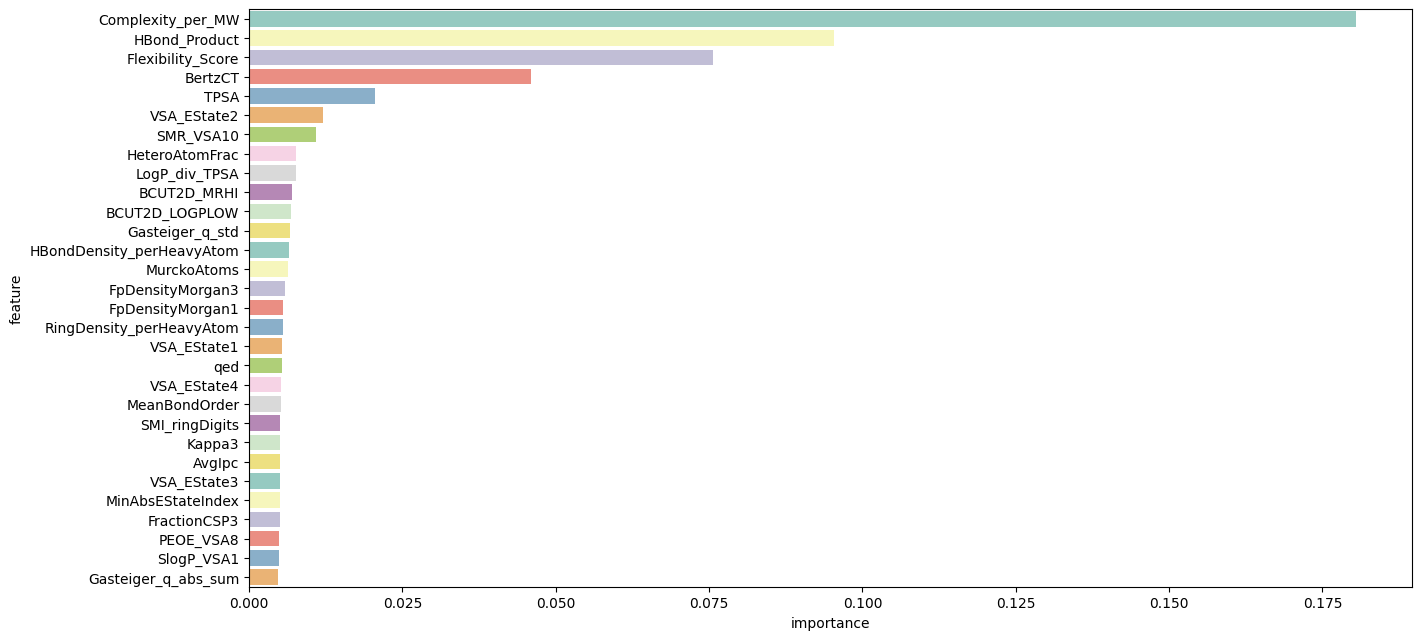

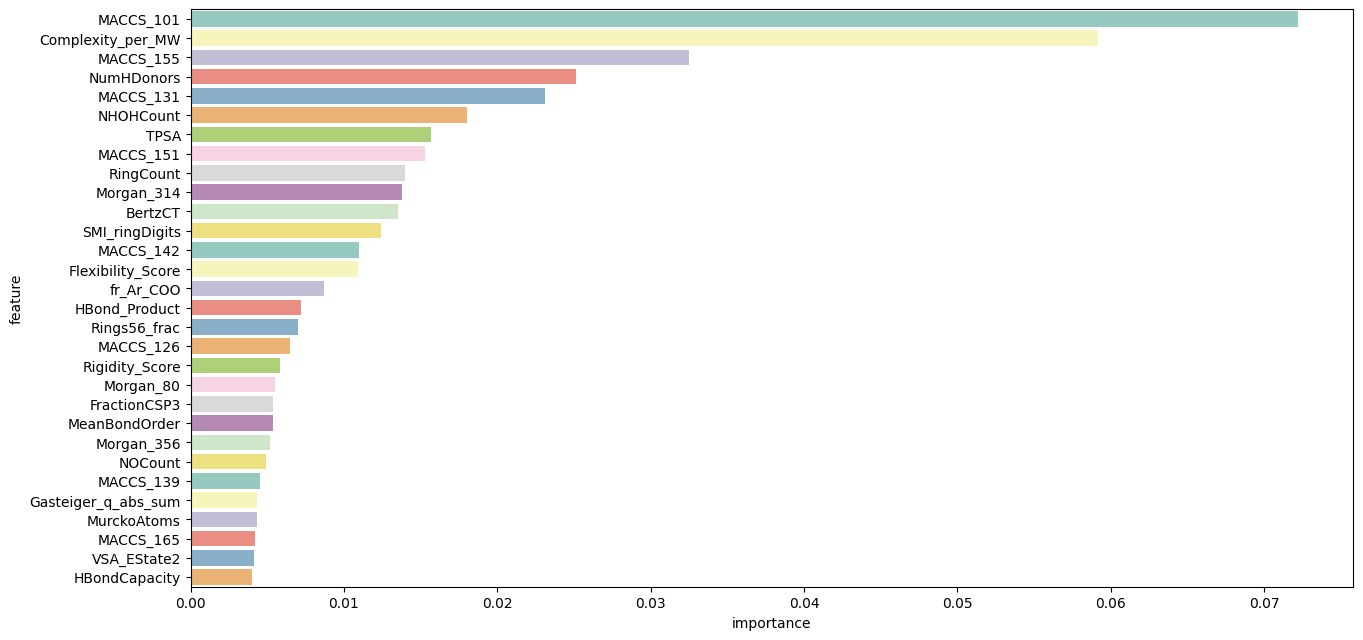

In [27]:
# check feature importance
importances = {}
for model_n, model_i in base_models.items():
    importances[model_n] = get_feature_importance(df_train, ["SMILES"], "Tm", model_i)

In [28]:
# top n features
def top_n_features(n, best=True):
    if best:
        top_n = set()
        for _, df_i in importances.items():
            top_n = top_n.union(set(df_i[:n].feature))  
        bottom_n = set(df_i.feature) - top_n  
    else:
        bottom_n = set()
        for _, df_i in importances.items():
            bottom_n = bottom_n.union(set(df_i[-n:].feature))  
        top_n = set(df_i.feature) - bottom_n
    return sorted(list(top_n)), sorted(list(bottom_n))

In [29]:
# try top n features
def score_in_test(X, y, model):
    """ score the given regression model on the validation data
    """
    # train / val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
    # model prediction
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    # get scores
    return regression_metrics(y_val, pred_val)

# NOTE: I am not gonna run this to keep notebook runtime fast - but please feel free to run this to have some kind of sophisticated feature selection
# Based on previous run, we will pick n=73 and best=False for now!
""" 
rows = []
for n in tqdm(range(1, 150)):
    for best in [True, False]:
        top_n, bottom_n = top_n_features(n, best)
        X, y = split_x_and_y(df_train, ["SMILES"] + bottom_n, "Tm")
        mae = score_in_test(X, y, base_models["lgbm"])["MAE"]  
        rows.append({"score": mae, "n": n, "best": best})
df_feat = pd.DataFrame(rows)
df_feat.sort_values(by="score", ascending=True, inplace=True)
df_feat[:5]
"""

' \nrows = []\nfor n in tqdm(range(1, 150)):\n    for best in [True, False]:\n        top_n, bottom_n = top_n_features(n, best)\n        X, y = split_x_and_y(df_train, ["SMILES"] + bottom_n, "Tm")\n        mae = score_in_test(X, y, base_models["lgbm"])["MAE"]  \n        rows.append({"score": mae, "n": n, "best": best})\ndf_feat = pd.DataFrame(rows)\ndf_feat.sort_values(by="score", ascending=True, inplace=True)\ndf_feat[:5]\n'

In [30]:
# default model (lgbm) cv score & with tuned features
# feature selection
#top_n, bottom_n = top_n_features(df_feat.n.iloc[0], df_feat.best.iloc[0])
top_n, bottom_n = top_n_features(73, False)
print(len(top_n), len(bottom_n))
# X / y split
X, y = split_x_and_y(df_train, ["SMILES"] + bottom_n, "Tm")
# cv predictions
pred_cv = cross_val_predict(base_models["lgbm"], X, y, cv=5) 
# score
regression_metrics(y, pred_cv)

570 303


{'R2': 0.577,
 'MAE': 33.845,
 'MAPE': 0.081,
 'RMSE': 43.614,
 'sample_size': 10000}

## 5.2. Hyperparameter Tuning

In [31]:
def objective_lgbm(trial):
    # set hyperparameter space
    params = {        
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000, step=250),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256), 
        "max_depth":trial.suggest_int("max_depth", 3, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 256),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0)
    }    
    
    # set model
    model = LGBMRegressor(random_state=42, verbose=-1, objective='regression_l1', metric='mae', **params)    
    # get score
    return score_in_test(X, y, model)["MAE"] 

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=5) 
# NOTE: this is just for showcasing! You guys can (or maybe should!) increase the n_trials first, and can also optimize using different hyperparameters!
study_lgbm.best_trial

FrozenTrial(number=3, state=1, values=[34.145], datetime_start=datetime.datetime(2025, 11, 21, 17, 56, 32, 573502), datetime_complete=datetime.datetime(2025, 11, 21, 17, 56, 38, 258844), params={'n_estimators': 1500, 'learning_rate': 0.04305556331583449, 'num_leaves': 99, 'max_depth': 3, 'min_child_samples': 119, 'lambda_l1': 9.02524048940972, 'lambda_l2': 0.8110007057717061, 'feature_fraction': 0.7448593588888834, 'bagging_fraction': 0.7913014138950216, 'bagging_freq': 3, 'subsample': 0.8507102899307317, 'colsample_bytree': 0.7411311348178107}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=2000, log=False, low=500, step=250), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'max_depth': IntDistribution(high=16, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=256, log=False, low=1, step=1), 'lambda_l1': FloatD

In [32]:
study_lgbm.best_params

{'n_estimators': 1500,
 'learning_rate': 0.04305556331583449,
 'num_leaves': 99,
 'max_depth': 3,
 'min_child_samples': 119,
 'lambda_l1': 9.02524048940972,
 'lambda_l2': 0.8110007057717061,
 'feature_fraction': 0.7448593588888834,
 'bagging_fraction': 0.7913014138950216,
 'bagging_freq': 3,
 'subsample': 0.8507102899307317,
 'colsample_bytree': 0.7411311348178107}

In [33]:
# set tuned model
tuned_model = LGBMRegressor(random_state=42, verbose=-1, objective='regression_l1', metric='mae', **study_lgbm.best_params)    
score_in_test(X, y, tuned_model)

{'R2': 0.559,
 'MAE': 34.145,
 'MAPE': 0.081,
 'RMSE': 44.216,
 'sample_size': 2500}

# 6. Inference

In [34]:
# train tuned model
tuned_model.fit(X, y)

LGBMRegressor(bagging_fraction=0.7913014138950216, bagging_freq=3,
              colsample_bytree=0.7411311348178107,
              feature_fraction=0.7448593588888834, lambda_l1=9.02524048940972,
              lambda_l2=0.8110007057717061, learning_rate=0.04305556331583449,
              max_depth=3, metric='mae', min_child_samples=119,
              n_estimators=1500, num_leaves=99, objective='regression_l1',
              random_state=42, subsample=0.8507102899307317, verbose=-1)

In [35]:
# get predictions
preds = tuned_model.predict(df_test[X.columns])
df_test["prediction"] = preds.copy()
df_test["id"] = sample_submission.id.copy()
df_test[["id", "SMILES", "Tm", "prediction"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          666 non-null    int64  
 1   SMILES      666 non-null    object 
 2   Tm          652 non-null    float32
 3   prediction  666 non-null    float64
dtypes: float32(1), float64(1), int64(1), object(1)
memory usage: 18.3+ KB


In [36]:
# submission
print(all(df_test.id == sample_submission.id))
df_test.Tm = df_test.Tm.fillna(df_test.prediction)
df_test[["id", "Tm"]].to_csv('df_submission.csv', index=False)

True
